### Todos
- Make with plotly last plot
- Make RandomSearch
- Rewrite 27
- Rewrite output with ranking

# FIFA World Cup 2022 Group Stage Prediction

I referenced a awesome kaggle notebook for creating this, here are the references.

Some weeks ago, i used a simple machine learning models to predict the result Group Stage just for fun and now i decided to publish it

https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner/notebook

In [1]:
import pandas as pd
import numpy as np

from itertools import combinations

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# <b><span style='color:#4797ef'>|</span> Import Data</b>

- `teams_df`: Qatar World Cup Participants Dataset
- `match_df`: International FIFA matches from 1993
- `rank_df`: FIFA Rankings Dataset


In [2]:
teams_df = pd.read_csv("data/Qatar2022-teams.csv", sep=";")
match_df = pd.read_csv("data/international_matches.csv")
rank_df = pd.read_csv("data/fifa_ranking-2022-10-06.csv")

Let's take a loot at each dataframes by `.head()`.

In [3]:
teams_df.head()

,Team,Group
0,Senegal,A
1,Qatar,A
2,Netherlands,A
3,Ecuador,A
4,Iran,B


In [4]:
match_df.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
rank_df.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


# <b><span style='color:#4797ef'>|</span> Data Validation</b>
- Standardize names of the countries that have differences

In [6]:
match_df = match_df.replace({"IR Iran": "Iran", "Korea Republic" : "South Korea"})
rank_df = rank_df.replace({"IR Iran": "Iran", "Korea Republic" : "South Korea"})

# <b><span style='color:#4797ef'>|</span> Data Processing for Training</b>

## Feature Engineering

In [7]:
match_df['rank_difference'] = match_df['home_team_fifa_rank'] - match_df['away_team_fifa_rank']
match_df['average_rank'] = (match_df['home_team_fifa_rank'] + match_df['away_team_fifa_rank'])/2
match_df['point_difference'] = match_df['home_team_total_fifa_points'] - match_df['away_team_total_fifa_points']
# indicates whether the match is Friendly or not. Some teams tend to not do their best on friendly matches
match_df['is_stake'] = match_df['tournament'] != 'Friendly'
# world cup matches
match_df['is_worldcup'] = 'FIFA World Cup' in match_df['tournament']

match_df['score_difference'] = match_df['home_team_score'] - match_df['away_team_score'] # Note that this feature is not used in training
match_df['is_won'] = match_df['score_difference'] > 0 # Take draw as lost


## Train-test Split

In [8]:
X, y = match_df.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake', 'is_worldcup']], match_df['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Feature Importance

In [9]:
numerical_vars = list(X_train.select_dtypes(include=np.number).columns)

In [10]:
aucs = dict()
for var in numerical_vars:
    auc_ = roc_auc_score(y_train, X_train[var])
    if auc_ < 0.5:
        auc_ = roc_auc_score(y_train, -X_train[var])
    aucs[var] = auc_    

In [11]:
sorted(aucs.items(), key=lambda x: x[1])

[('average_rank', 0.5235562829433418),
 ('point_difference', 0.6242306616113044),
 ('rank_difference', 0.7432519077426949)]

# <b><span style='color:#4797ef'>|</span> Modelling</b>

In [12]:
logreg = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
gaussian = GaussianNB()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=100)

## Logistic Regression

In [13]:
logreg.fit(X_train, y_train)
lg_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_test, y_test) * 100, 2)
acc_log

68.38

## Support Vector Machines

In [14]:
svc.fit(X_train, y_train)
svm_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_test, y_test) * 100, 2)
acc_svc

68.17

## KNN

In [15]:
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, y_test) * 100, 2)
acc_knn

C:\Users\hugom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hugom\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

62.88

## Gaussian Naive Bayes

In [16]:
gaussian.fit(X_train, y_train)
gnb_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, y_test) * 100, 2)
acc_gaussian

68.36

## Decision Tree

In [17]:
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
acc_decision_tree

59.12

## Random Forest

In [18]:
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
acc_random_forest

64.83

In [19]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Logistic Regression,68.38
4,Naive Bayes,68.36
0,Support Vector Machines,68.17
3,Random Forest,64.83
1,KNN,62.88
5,Decision Tree,59.12


I'll use Logistic Regression for final prediction. Ensembling top 3 models may work better though.

In [20]:
model = logreg

# Prediction

Now, we have to manually create rows for Qatar 2022 matches. 

Also, we're going to define a small margin to handle situations safer to predict draw then win.

In [21]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
rank_df = rank_df.loc[(rank_df['rank_date'] == rank_df['rank_date'].max()) & (rank_df['country_full'].isin(teams_df['Team'].unique()))]

worldcup_rankings = rank_df.set_index(['country_full'])

In [22]:
worldcup_rankings.head()

,rank,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
country_full,,,,,,,
Brazil,1,BRA,1841.30,1837.56,0,CONMEBOL,2022-10-06
South Korea,28,KOR,1530.30,1526.02,0,AFC,2022-10-06
Tunisia,30,TUN,1507.54,1507.86,0,CAF,2022-10-06
Costa Rica,31,CRC,1503.59,1500.06,-3,CONCACAF,2022-10-06
Australia,38,AUS,1488.72,1483.73,-1,AFC,2022-10-06


In [23]:
worldcup_rankings.index.unique()

Index(['Brazil', 'South Korea', 'Tunisia', 'Costa Rica', 'Australia', 'Canada',
       'Cameroon', 'Ecuador', 'Poland', 'Japan', 'Belgium', 'Argentina',
       'France', 'England', 'Spain', 'Netherlands', 'Portugal', 'Denmark',
       'Germany', 'Croatia', 'Mexico', 'Uruguay', 'Switzerland', 'USA',
       'Senegal', 'Wales', 'Iran', 'Serbia', 'Morocco', 'Qatar',
       'Saudi Arabia', 'Ghana'],
      dtype='object', name='country_full')

I will save the model predictions on `world_cup` dataframe and `country_win_prob` dictionary. Also, as I'm Korean, I made a separate list to save result on`korea_win_prob` list.

In [24]:
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup = teams_df.set_index(['Team'])
world_cup['points'] = 0
world_cup['total_prob'] = 0
world_cup['expected points'] = 0
world_cup['rank'] = None

country_win_prob = {}

for country in teams_df['Team'].unique():
    country_win_prob[country] = list()

# <b><span style='color:#4797ef'>|</span> Group Stage Prediction</b>

In [25]:
for group in sorted(set(teams_df['Group'])):
    print('___Group {}:___'.format(group))

    for home, away in combinations(teams_df.query('Group == "{}"'.format(group)).values, 2):
        print("{} vs. {}: ".format(home[0], away[0]), end='')
    
        home = home[0]
        away = away[0]
        
        # Create a row for each match
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True, True]]), columns=X_train.columns)

        home_rank = worldcup_rankings.loc[home, 'rank']
        home_points = worldcup_rankings.loc[home, 'total_points']
        opp_rank = worldcup_rankings.loc[away, 'rank']
        opp_points = worldcup_rankings.loc[away, 'total_points']
        world_cup.loc[home, 'rank'] = home_rank
        world_cup.loc[away, 'rank'] = opp_rank

        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        # Model Output
        home_win_prob = model.predict_proba(row)[:,1][0]
        
        
        # Saving Model Output
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob

        country_win_prob[home].append(home_win_prob)
        country_win_prob[away].append(1-home_win_prob)
        
        # Determining Win / Draw / Lose based on home_win_prob
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
            world_cup.loc[away, 'expected points'] += (1-home_win_prob) * 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            world_cup.loc[home, 'expected points'] += home_win_prob * 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            world_cup.loc[home, 'expected points'] += home_win_prob * 1
            world_cup.loc[away, 'expected points'] += (1-home_win_prob) * 1

___Group A:___
Senegal vs. Qatar: Senegal wins with 0.62
Senegal vs. Netherlands: Netherlands wins with 0.61
Senegal vs. Ecuador: Senegal wins with 0.59
Qatar vs. Netherlands: Netherlands wins with 0.74
Qatar vs. Ecuador: Ecuador wins with 0.57
Netherlands vs. Ecuador: Netherlands wins with 0.64
___Group B:___
Iran vs. England: England wins with 0.63
Iran vs. USA: USA wins with 0.57
Iran vs. Wales: Wales wins with 0.56
England vs. USA: Draw
England vs. Wales: Draw
USA vs. Wales: Draw
___Group C:___
Argentina vs. Saudi Arabia: Argentina wins with 0.69
Argentina vs. Mexico: Draw
Argentina vs. Poland: Argentina wins with 0.57
Saudi Arabia vs. Mexico: Mexico wins with 0.73
Saudi Arabia vs. Poland: Poland wins with 0.67
Mexico vs. Poland: Draw
___Group D:___
Denmark vs. Tunisia: Denmark wins with 0.55
Denmark vs. France: France wins with 0.59
Denmark vs. Australia: Denmark wins with 0.60
Tunisia vs. France: France wins with 0.68
Tunisia vs. Australia: Draw
France vs. Australia: France wins 

## Expected Points

In [26]:
for group in sorted(set(teams_df['Group'])):
    print('___Group {}:___'.format(group))
    teams = teams_df.query('Group == "{}"'.format(group)).values
    for team_info in teams:
        team_name = team_info[0]
        print(team_name, ": ", world_cup.loc[team_name, "expected points"])

___Group A:___
Senegal :  3.6079965458122643
Qatar :  0.0
Netherlands :  5.959668575161052
Ecuador :  1.7127215169764838
___Group B:___
Iran :  0.0
England :  2.9227495013352045
USA :  2.6840236954486825
Wales :  2.6832559153963644
___Group C:___
Argentina :  4.286353942719144
Saudi Arabia :  0.0
Mexico :  3.1963192020317854
Poland :  2.481271369033881
___Group D:___
Denmark :  3.4485978500610264
Tunisia :  0.4945877992220571
France :  5.696886533016041
Australia :  0.5054122007779429
___Group E:___
Germany :  2.178141394621764
Japan :  0.9728076701631958
Spain :  5.380953594716832
Costa Rica :  0.511359888856254
___Group F:___
Morocco :  1.652644981266103
Croatia :  3.6146314412505074
Belgium :  5.7678391556116795
Canada :  0.0
___Group G:___
Switzerland :  2.2706012878512096
Cameroon :  0.0
Brazil :  5.810936160477053
Serbia :  2.482411222170502
___Group H:___
Uruguay :  2.5899996526460924
South Korea :  2.3520097476957256
Portugal :  5.816296001915481
Ghana :  0.0


## Group Stage Survival Probability

I assumed if a country has 2 or more wins, then they survive in Group Stage.

In [27]:
country_total_prob = []

for country in country_win_prob.keys():
    win_prob_list = country_win_prob[country]

    total_prob = 0
    temp = 1
    for i in range(3):
        temp = temp * win_prob_list[i]

    total_prob += temp

    for i in range(3):
        temp = 1
        for j in range(3):
            if i == j:
                temp = temp * (1 - win_prob_list[i])
            else:
                temp = temp * win_prob_list[i]
        total_prob += temp
    
    country_total_prob.append((country, total_prob))
    
    print(country, ":", total_prob)

Senegal : 0.5238123555510896
Qatar : 0.28657994414763266
Netherlands : 0.7207123136586892
Ecuador : 0.4107822279220528
Iran : 0.3683189762811535
England : 0.5691708021782123
USA : 0.5126970678459446
Wales : 0.5323556070273117
Argentina : 0.6086463678095058
Saudi Arabia : 0.2221542863970168
Mexico : 0.5868558522665446
Poland : 0.5128567082594241
Denmark : 0.5151762204409139
Tunisia : 0.37210405029512583
France : 0.6893043301262857
Australia : 0.3877831877546304
Germany : 0.4893859548936814
Japan : 0.41097390771037756
Spain : 0.6419635779920858
Costa Rica : 0.43841533837914887
Morocco : 0.3819955705681708
Croatia : 0.5217642297484982
Belgium : 0.7041053684174785
Canada : 0.34822417001400974
Switzerland : 0.45510860867745
Cameroon : 0.25700333565836253
Brazil : 0.6878946534259281
Serbia : 0.5383228703970194
Uruguay : 0.5313857116348001
South Korea : 0.45081127452719727
Portugal : 0.7025008859381351
Ghana : 0.2479054328407199


Let's sort `country_total_prob` to see which country has the highest probability to survive the group stage.

In [28]:
country_total_prob = sorted(country_total_prob, key=lambda x: x[1], reverse=True)

country_total_prob

[('Netherlands', 0.7207123136586892),
 ('Belgium', 0.7041053684174785),
 ('Portugal', 0.7025008859381351),
 ('France', 0.6893043301262857),
 ('Brazil', 0.6878946534259281),
 ('Spain', 0.6419635779920858),
 ('Argentina', 0.6086463678095058),
 ('Mexico', 0.5868558522665446),
 ('England', 0.5691708021782123),
 ('Serbia', 0.5383228703970194),
 ('Wales', 0.5323556070273117),
 ('Uruguay', 0.5313857116348001),
 ('Senegal', 0.5238123555510896),
 ('Croatia', 0.5217642297484982),
 ('Denmark', 0.5151762204409139),
 ('Poland', 0.5128567082594241),
 ('USA', 0.5126970678459446),
 ('Germany', 0.4893859548936814),
 ('Switzerland', 0.45510860867745),
 ('South Korea', 0.45081127452719727),
 ('Costa Rica', 0.43841533837914887),
 ('Japan', 0.41097390771037756),
 ('Ecuador', 0.4107822279220528),
 ('Australia', 0.3877831877546304),
 ('Morocco', 0.3819955705681708),
 ('Tunisia', 0.37210405029512583),
 ('Iran', 0.3683189762811535),
 ('Canada', 0.34822417001400974),
 ('Qatar', 0.28657994414763266),
 ('Cameroon

<AxesSubplot:xlabel='Country'>

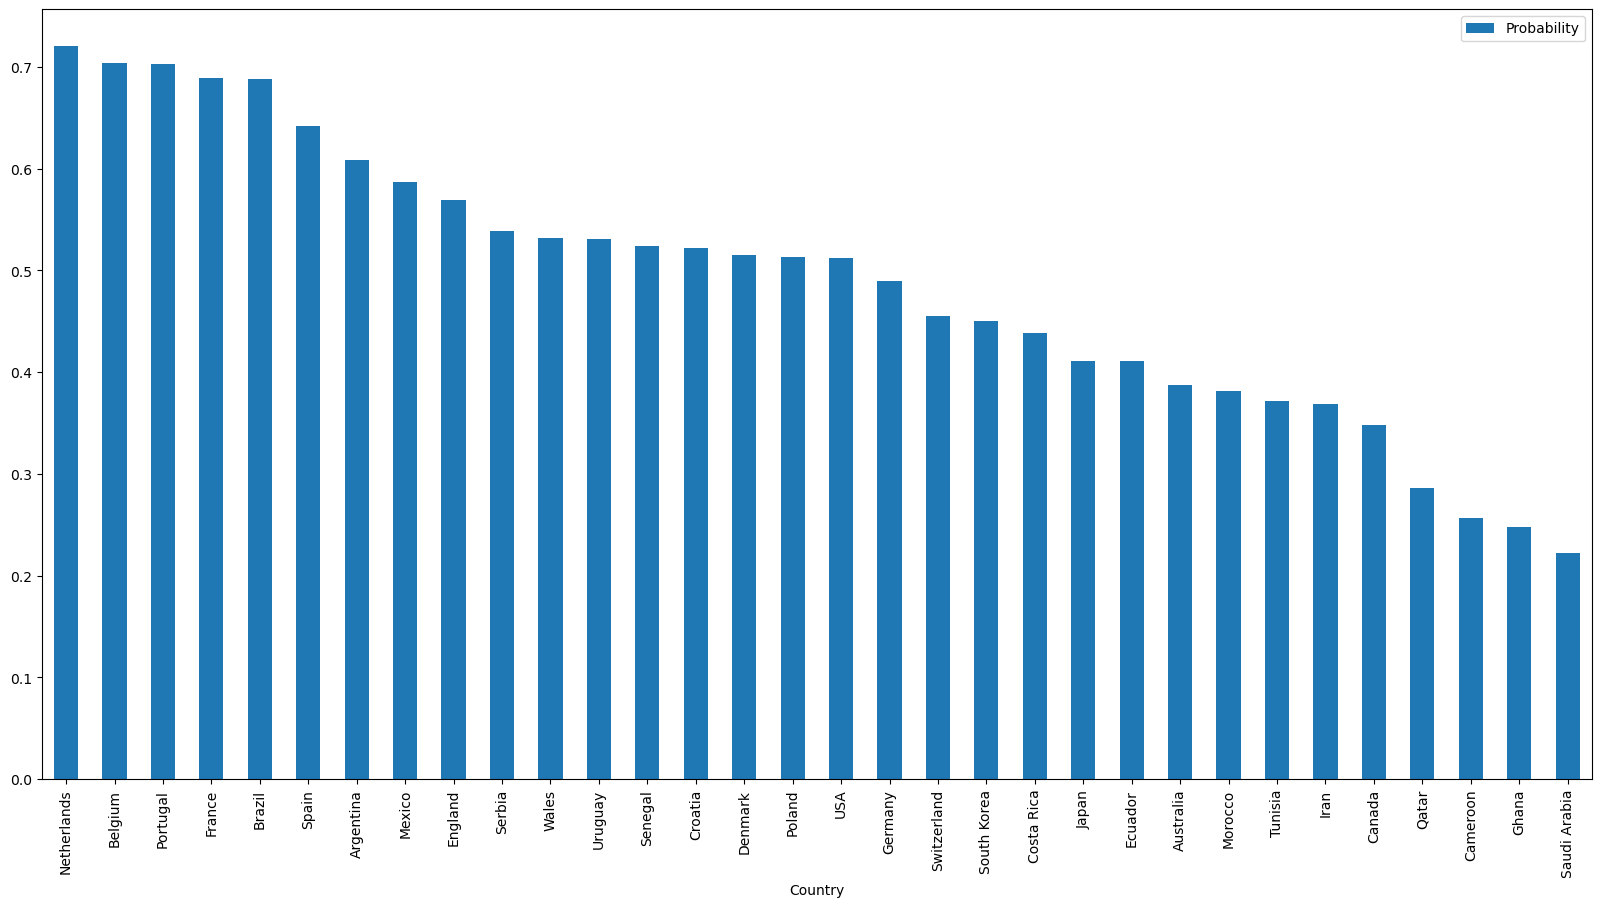

In [29]:
prob_df = pd.DataFrame(country_total_prob, columns =['Country', 'Probability']) 

prob_df.plot(x="Country", y="Probability", kind="bar", figsize=(20,10))